In [1]:
import copy
import random
import re

import pandas
import numpy

from curve_fits import Call, Spec

from curve_fits import curves
from curve_fits import fits
from curve_fits import frames

In [2]:
def random_ints_sample(size, max_abs=10000):
    return random.sample(range(-max_abs, max_abs), k=size)

In [3]:
size_range = range(1050, 1750)
overfit = 1  # HIGH to differentiate from single-line shape
init_calls = [Call(random_ints_sample(size)) for size in size_range]
profile = frames.TimeComplexityProfile('set', init_calls, {'pop': Call(), 'copy': Call()},
    index=pandas.Index(size_range, name='List length'), overfit=overfit, fraction=0.9, loops=100)

In [4]:
profile.fit_all_with(
    Call(Spec(curves.Polynomial, 2), Spec(curves.Log, 1, pole=10), initial_params=[-1, 1, -1]),
    Call(Spec(curves.Xlog, 1), Spec(curves.InverseXPolynomial, 1)), piecewise=[
    Call([x], *[Call(Spec(curves.Polynomial, 2))]*2) for x in range(1300, 1420)])

In [5]:
profile.best_fits(limit=3)

kind  \
key  cost                                 
pop  0.011277  PW:Poly(1)-[1364]Poly(1)   
     0.011596  PW:Poly(1)-[1367]Poly(1)   
     0.012508  PW:Poly(1)-[1363]Poly(1)   
copy 0.010769  PW:Poly(1)-[1364]Poly(1)   
     0.011493  PW:Poly(1)-[1363]Poly(1)   
     0.011674  PW:Poly(1)-[1365]Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.011277  (-0.0058 ± 0.0042) + (0.0000489 ± 0.0000035)x ...   4  
     0.011596  (-0.0096 ± 0.0044) + (0.0000522 ± 0.0000036)x ...   4  
     0.012508  (-0.0054 ± 0.0048) + (0.0000488 ± 0.0000040)x ...   4  
copy 0.010769  (0.0188 ± 0.0026) + (0.0000542 ± 0.0000021)x |...   4  
     0.011493  (0.0184 ± 0.0026) + (0.0000545 ± 0.0000022)x |...   4  
     0.011674  (0.0179 ± 0.0027) + (0.0000550 ± 0.0000022)x |...   4

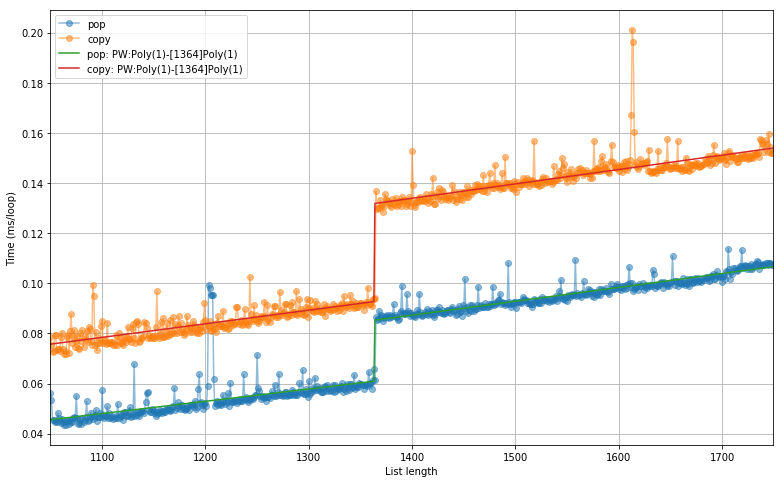

In [6]:
fig, ax = profile.plot(limit=1)

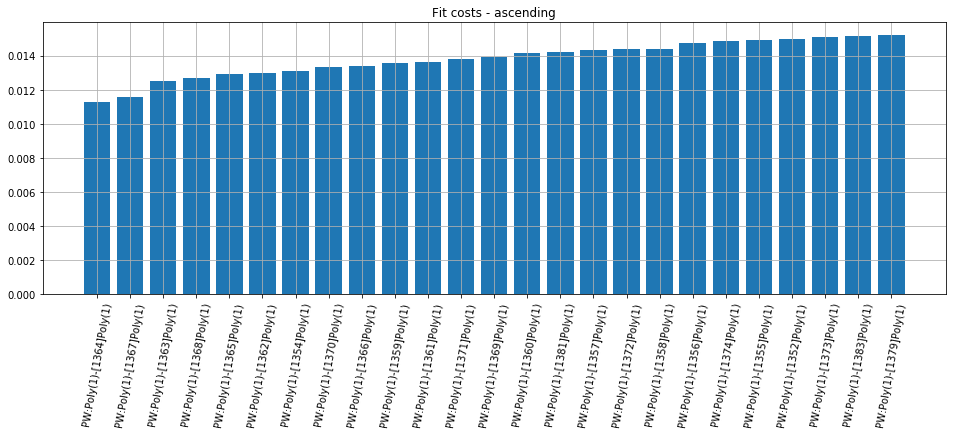

In [7]:
fig, ax = profile.plot_costs('pop', limit=25, rotation=80)

In [8]:
all_fits = profile.best_fits(limit=None)
all_fits[(all_fits.kind == 'Log+Poly(1)') | (all_fits.kind == 'Poly(-1)+Xlog')]

kind  \
key  cost                      
pop  0.020237    Log+Poly(1)   
     0.020331  Poly(-1)+Xlog   
copy 0.028314    Log+Poly(1)   
     0.029243  Poly(-1)+Xlog   

                                                             fit DOF  
key  cost                                                             
pop  0.020237  (-0.56 ± 0.19) + (0.000046 ± 0.000022)x + (0.0...   3  
     0.020331      (0.000010239 ± 9.6E-8)log[] + (-37.0 ± 1.3)/s   2  
copy 0.028314  (-0.96 ± 0.26) + (0.000035 ± 0.000031)x + (0.1...   3  
     0.029243       (0.00001436 ± 1.4E-7)log[] + (-40.0 ± 1.9)/s   2

In [9]:
pop_fit = profile.best_fit('pop')
pop_fit, pop_fit.curve

(<PiecewiseFit: (-0.0058 ± 0.0042) + (0.0000489 ± 0.0000035)x | (0.0098 ± 0.0020) + (0.0000553 ± 0.0000013)x>,
 <Piecewise: (-0.005818275317638747) + (4.8937304499950525e-05)x | (0.009803607655656597) + (5.534365305694619e-05)x>)

In [10]:
pop_fit.fits, pop_fit.jumps_at

((<CurveFit: (-0.0058 ± 0.0042) + (0.0000489 ± 0.0000035)x>,
  <CurveFit: (0.0098 ± 0.0020) + (0.0000553 ± 0.0000013)x>),
 (1364,))

In [11]:
pop_fit.fits[1].measures

(<Measure: 0.0098 ± 0.0020>, <Measure: 0.0000553 ± 0.0000013>)

In [12]:
pop_fit_copy = copy.deepcopy(pop_fit)
pop_fit_copy.series = None   # Mocked to show equality is not affected
assert pop_fit == copy.deepcopy(pop_fit)

In [13]:
pop_fit_call = Call(pop_fit.jumps_at, *[Call(Spec(curves.Polynomial, 2))]*2)
assert pop_fit != fits.PiecewiseFit(profile.data['pop'], *pop_fit_call.args, **pop_fit_call.kwargs)

In [14]:
assert [re.sub(r'\[[0-9]{3,}\]', '', kind) for kind in profile.best_fits(limit=1)['kind']] == [
    'PW:Poly(1)-Poly(1)', 'PW:Poly(1)-Poly(1)']